# Libraries

In [ ]:
# IO
import os
import pathlib
from pathlib import Path
from glob import glob
import cv2
from typing import Any, Callable, cast, Dict, List, Optional, Tuple, Union
from PIL import Image
import json

# Utilities
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn import preprocessing
from sklearn.base import BaseEstimator

import random
import math
from collections import defaultdict

from functools import partial

# Pytorch
import torch
from torch import nn

# Torchvision
import torchvision
from torchvision.datasets.vision import VisionDataset
from torchvision import datasets
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision.transforms import ToTensor
from torchvision import transforms
from torchvision.io import read_image
## torchvision utilities
from torch.utils.data import DataLoader, TensorDataset, Subset
from torch.utils.data import Dataset
from torchvision.datasets.folder import IMG_EXTENSIONS, default_loader
from torch.utils.tensorboard import SummaryWriter

# Optuna
import optuna

# Visualization
#import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.colors as mcolors

#matplotlib.use(backend="TkAgg")
# Progress bar
import sys
from tqdm import tqdm

In [2]:
# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.4.1.post102
torchvision version: 0.19.1a0+5ed21bd


# Define global variables

Smallest image dimension, all bigger image will be cropped to this value

In [3]:
DIM = 64

IO folders, I tried to make this os-agnostic

In [4]:
CodeDirectory = Path(os.path.abspath(''))
DATASET_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_data","")
DATASET_PATH = Path(DATASET_FOLDER)
BROKENDATA_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_brokenData","")
LOGGING_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_output_data","")

# Functions and Classes definitions

## Data Preparation

Define set of image transformations, boolean switch for color images

In [5]:
def TransformationComposer(dimension=256, color=True):
    if color:
        return transforms.Compose([
            #transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Resize(dimension),
            transforms.RandomCrop(dimension*(7/8)),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    else:
        return transforms.Compose([
            #transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Resize(dimension),
            transforms.RandomCrop(dimension*(7/8)),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Grayscale(1)
        ])

This function scans the dataset folder, discarding images that are smaller than a target dimension Dim or just broken (NULL type)

In [6]:
def ImageFolderScan(ImageDir,Dim):
    subfolder_list = glob(os.path.join(ImageDir,"*","*",""), recursive = True)
    for i in range(len(subfolder_list)):
        for filename in os.listdir(subfolder_list[i]):
            image_path = str(subfolder_list[i]+filename)
            image = cv2.imread(image_path)
            # If pic is broken
            if image is None:
                os.rename(image_path, BROKENDATA_FOLDER+os.path.basename(os.path.normpath(subfolder_list[i]))+filename)
            else:
                # If pic is too small, threshold 256x256
                height, width, channels = image.shape
                if min(height,width)<Dim:
                    os.rename(image_path, BROKENDATA_FOLDER+os.path.basename(os.path.normpath(subfolder_list[i]))+filename)

Create a customized ImageFolder class so that we can define classes from subsubdirectories (more specific classifier)

Given how ImageFolder handles getting the datapoints, the elements in class_to_idx should resemble the relative path from the root directory

In [7]:
class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        # Initialize the parent class (ImageFolder) correctly
        super().__init__(root, transform=transform)

    def find_classes(self, directory):
            """Finds the classes and maps them to indices."""
            subfolders = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
            
            classes = []
            class_to_idx = {}
            
            # Iterate over each subfolder
            for subfolder in subfolders:
                subfolder_path = os.path.join(directory, subfolder)
                # Get sub-subfolders
                for class_name in os.listdir(subfolder_path):
                    class_path = os.path.join(subfolder_path, class_name)
                    if os.path.isdir(class_path):
                        classes.append(os.path.join(subfolder, class_name))  # Add the class name
                        # Create a dictionary for classes and class indices
                        class_to_idx[os.path.join(subfolder, class_name)] = len(class_to_idx)

            return classes, class_to_idx

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, data, indices, transform=None):
        self.data = data  # Assuming `data` is similar to ImageFolder with `samples` and `targets`
        self.indices = indices  # Indices to select specific data points
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Retrieve the sample (img_path, label) using the provided indices
        img_path, label = self.data.samples[self.indices[idx]]
        
        # Open the image and apply any transformations
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

    @property
    def samples(self):
        # Return the subset of samples based on the provided indices
        return [(self.data.samples[i][0], self.data.samples[i][1]) for i in self.indices]

    @property
    def images(self):
        # Return the subset of samples based on the provided indices
        return [self.data.samples[i][0] for i in self.indices]

    @property
    def targets(self):
        # Return the labels for the subset of samples
        return [self.data.samples[i][1] for i in self.indices]

Stratified sampling

In [9]:
def StratifiedSplit(data, test_size_fraction=0.3):
    targets = np.array(data.targets)
    train_idx, test_idx = train_test_split(
        np.arange(len(data)),
        test_size=test_size_fraction,
        shuffle=True,
        stratify=targets
    )

    # Return indices only
    return train_idx, test_idx


## Visualizations

Visualize Stratified Kfold

In [10]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10, train_title='Training set', test_title='Testing set'):
    """Create a sample plot for indices of a cross-validation object."""
    # Sort X and y according to y to keep the classes in order
    sorted_indices = np.argsort(y)
    X_sorted = X[sorted_indices]
    y_sorted = y[sorted_indices]

    # Define colormaps for CV splits and data classes
    cmap_cv = plt.cm.coolwarm  # Used for training/testing splits
    cmap_data = plt.cm.tab10  # Used for data classes

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X_sorted, y=y_sorted)):
        # Fill in indices with the training/test labels
        indices = np.array([np.nan] * len(X_sorted))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes at the end
    # Use class labels as colors with a unique color per class
    unique_classes = np.unique(y_sorted)
    norm = mcolors.BoundaryNorm(boundaries=np.arange(len(unique_classes) + 1) - 0.5, ncolors=len(unique_classes))
    scatter = ax.scatter(
        range(len(X_sorted)),
        [ii + 1.5] * len(X_sorted),
        c=y_sorted,
        marker="_",
        lw=lw,
        cmap=cmap_data,
        norm=norm
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class"]
    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, len(X_sorted)],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)

    # Create combined legend
    # Legend for CV splits (Training and Testing)
    test_title_str = test_title
    train_title_str = train_title

    handles_cv = [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))]
    labels_cv = [test_title, train_title]

    # Legend for class labels
    legend_labels = [f"Class {cls}" for cls in unique_classes]
    handles_classes = scatter.legend_elements()[0]  # Extract handles for the class labels

    # Combine handles and labels for both legends
    handles = handles_cv + handles_classes
    labels = labels_cv + legend_labels

    # Add the combined legend
    ax.legend(handles=handles, labels=labels, loc="upper left", bbox_to_anchor=(1.05, 1))

    return ax

In [11]:
def StratifiedKFoldVisual(dataset, cv, mask_len = 3, train_title='Training set', test_title='Testing set'):
    X = [sample[0] for sample in dataset.samples]  # Paths or images
    y = dataset.targets  # Labels (class indices)

    unique_classes = np.unique(y)[:mask_len]
    mask = np.isin(y, unique_classes)

    X_limited = np.array(X)[mask]
    y_limited = np.array(y)[mask]

    cmap_data = plt.cm.Paired
    cmap_cv = plt.cm.coolwarm

    fig, ax = plt.subplots()
    plot_cv_indices(cv, X_limited, y_limited, ax, cv.get_n_splits(), train_title=train_title, test_title=test_title)

Plot losses and accuracies

In [12]:
def plot_metrics(log_file_path):
    # Check if the log file exists and is not empty
    if not os.path.exists(log_file_path) or os.stat(log_file_path).st_size == 0:
        print("The log file does not exist or is empty. Cannot plot metrics.")
        return
    
    # Initialize lists to store data
    epochs = []
    training_loss = []
    training_acc = []
    validation_loss = []
    validation_acc = []

    # Read the log file
    with open(log_file_path, "r") as log_file:
        # Skip the header
        next(log_file)
        # Parse the content
        for line in log_file:
            values = line.strip().split('\t')
            epochs.append(int(values[0]))
            training_loss.append(float(values[1]))
            training_acc.append(float(values[2]))
            validation_loss.append(float(values[3]))
            validation_acc.append(float(values[4]))

    # Plot the metrics
    plt.figure(figsize=(12, 6))

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, label='Training Loss', marker='o')
    plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, validation_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()

    # Show the plots
    plt.tight_layout()
    plt.show()

## Training

Basic training loop (one epoch)

In [ ]:
def training_epoch(model, optimizer, loss_crit, train_loader, device):
    avg_train_loss = 0
    correct_train = 0
    total_train = 0
    for batch_x, batch_y in train_loader:
        print('loading batches')
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # Move data to device
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_crit(outputs, batch_y)
        loss.backward()
        optimizer.step()

        # Accumulate training loss and accuracy
        avg_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == batch_y).sum().item()
        total_train += batch_y.size(0)
    
    # Average training loss and accuracy over batches
    avg_train_loss /= len(train_loader)
    avg_train_accuracy = correct_train / total_train

    return avg_train_loss, avg_train_accuracy

Basic validation loop, returning validation loss and accuracy averaged on batches

In [14]:
def validation_epoch(model, criterion, val_loader, device):
    avg_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # Move data to device
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            # Accumulate validation loss and accuracy
            avg_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == batch_y).sum().item()
            total_val += batch_y.size(0)
    # Average validation loss for the fold
    avg_val_loss /= len(val_loader)
    avg_val_accuracy = correct_val / total_val
    
    return avg_val_loss, avg_val_accuracy

Early stopper class

In [15]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0, compare_steps=5):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.compare_steps = compare_steps
        self.loss_history = []

    def early_stop(self, validation_loss):
        self.loss_history.append(validation_loss)

        # Update best validation loss
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.reset()  # Reset state before stopping
                return True

        # Compare current loss with `compare_steps` earlier
        if len(self.loss_history) > self.compare_steps:
            if validation_loss >= (self.loss_history[-(self.compare_steps + 1)] - self.min_delta):
                self.reset()  # Reset state before stopping
                return True

        # Maintain history size
        if len(self.loss_history) > self.compare_steps + 1:
            self.loss_history.pop(0)

        return False

    def reset(self):
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.loss_history = []

Final training loop

In [ ]:
def train_loop(dataset, model_class, hyperparams, criterion, device, early_stopper, out_str, max_epochs=100):
    # Get hyperparameters from best study
    batch_size = hyperparams.get('batch_size', 32)  # Default to 32 if not provided
    learning_rate = hyperparams.get('lr', 0.001)  # Default to 0.001 if not provided
    optimizer_name = hyperparams.get('optimizer_name', 'Adam')  # Default to Adam if not provided
    wd = hyperparams.get('weight_decay', 0.001) # Default to 0.001 if not provided
    hidden_channels = hyperparams.get('hidden_channels') # Default to 0.001 if not provided

    model = model_class(n_channels=1, hidden_channels=hidden_channels, output_shape=len(set(dataset.targets)))
    model.to(device)
    
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate, weight_decay=wd)

    # Check if the file is empty or does not exist
    if not os.path.exists(out_str) or os.stat(out_str).st_size == 0:
        # File does not exist or is empty, create it
        log_file = open(out_str, "w")
        log_file.write('epoch'+'\t'+'training_loss'+'\t'+'training_acc'+'\t'+'validation_loss'+'\t'+'validation_acc'+'\n')
    else:
        # File exists, append
        log_file = open(out_str, "a")

    # Create indices for stratified split
    train_idx, val_idx = StratifiedSplit(dataset, test_size_fraction=0.2)

    # Create data subsets for train and validarion
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)

    # Create loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    total_step = len(train_loader)

    for epoch in range(max_epochs):
        model.train()
        print(f'Train step, epoch: {epoch+1}')
        train_loss, train_acc = training_epoch(model, optimizer, criterion, train_loader, device)
        print(f'Epoch: {epoch+1}, train loss = {train_loss}, train accuracy = {train_acc}')

        # Early stopping and validation
        print(f'Val step, epoch: {epoch+1}')
        model.eval()
        val_loss, val_acc = validation_epoch(model, criterion, val_loader, device)
        print(f'Epoch: {epoch+1}, validation loss = {val_loss}, validation accuracy = {val_acc}')

        if early_stopper.early_stop(val_loss):
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

        # Logging
        log_file.write(f"{epoch}\t{train_loss:.4f}\t{train_acc:.4f}\t{val_loss:.4f}\t{val_acc:.4f}\n")

    log_file.close()
    return model

### Hyperparameter tuning

Cross Validation training.
We are using the Optima library to search the optimal hyperparameters.

An early stopping policy is implemented to reduce run time and avoid overfitting.

We have to train independently over the folds

The hyperparameters to be searched are:
- batch size
- optimizer
- learning rate (logarithmic sampling)
- weight decay (logarithmic sampling)

In [18]:
def objective_vgg(trial, dataset, model, criterion, cross_validator, device, early_stopper):

    num_epochs = 10

    # Sample hyperparameters
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    wd = trial.suggest_float("weight_decay", 1e-4, 1e-1, log=True)

    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=wd)

    # Ensure model and criterion are on the correct device
    model.to(device)
    criterion.to(device)

    # Split into image and targets for the cross validator split
    X_train = np.array(dataset.images)
    y_train = np.array(dataset.targets)

    # To store validation and training losses and accuracies for each fold
    val_losses_over_folds = []
    train_losses_over_folds = []
    val_accs_over_folds = []
    train_accs_over_folds = []

    for fold, (train_idx, val_idx) in enumerate(tqdm(cross_validator.split(X_train, y_train), desc="Folds", unit="fold")):
        early_stopper.reset()
        
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        val_losses = []
        train_losses = []
        val_accs = []
        train_accs = []

        model_copy = model
        model_copy.to(device)

        for epoch in tqdm(range(num_epochs), desc=f"Fold {fold + 1} Epochs", unit="epoch", leave=False):
            model_copy.train()
            train_loss, train_acc = training_epoch(model_copy, optimizer, criterion, train_loader, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            model_copy.eval()
            val_loss, val_acc = validation_epoch(model_copy, criterion, val_loader, device)
            if early_stopper.early_stop(val_loss):
                break

            val_losses.append(val_loss)
            val_accs.append(val_acc)

        train_losses_over_folds.append(train_losses)
        train_accs_over_folds.append(train_accs)
        val_losses_over_folds.append(val_losses)
        val_accs_over_folds.append(val_accs)

    avg_last_val_loss = np.mean([losses[-1] for losses in val_losses_over_folds])
    trial.set_user_attr("val_losses_over_folds", val_losses_over_folds)
    trial.set_user_attr("train_losses_over_folds", train_losses_over_folds)
    trial.set_user_attr("val_accs_over_folds", val_accs_over_folds)
    trial.set_user_attr("train_accs_over_folds", train_accs_over_folds)

    return avg_last_val_loss

In [ ]:
def objective_coppo(trial, dataset, model_class, criterion, cross_validator, device, early_stopper):
    num_epochs = 10

    # Sample hyperparameters
    batch_size = 32
    optimizer_name = "Adam"
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    wd = trial.suggest_float("weight_decay", 1e-4, 1e-1, log=True)

    # Define possible channel configurations
    hidden_channel_choices = [
        [4, 8, 16, 32, 48, 64],
        [6, 16, 32, 64, 96, 128],
        [3, 9, 15, 30, 45, 90]
    ]
    hidden_channels = trial.suggest_categorical("hidden_channels", hidden_channel_choices)

    # Create a fresh model instance with the selected configuration
    model = model_class(n_channels=1, hidden_channels=hidden_channels, output_shape=len(set(dataset.targets)))
    model.to(device)
    criterion.to(device)

    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=wd)

    # Split into image and targets for the cross-validator split
    X_train = np.array(dataset.images)
    y_train = np.array(dataset.targets)

    # To store validation and training losses and accuracies for each fold
    val_losses_over_folds = []
    train_losses_over_folds = []
    val_accs_over_folds = []
    train_accs_over_folds = []

    for fold, (train_idx, val_idx) in enumerate(tqdm(cross_validator.split(X_train, y_train), desc="Folds", unit="fold")):
        early_stopper.reset()
        
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        val_losses = []
        train_losses = []
        val_accs = []
        train_accs = []
        
        model_copy = model
        model_copy.to(device)

        for epoch in tqdm(range(num_epochs), desc=f"Fold {fold + 1} Epochs", unit="epoch", leave=False):
            model_copy.train()
            train_loss, train_acc = training_epoch(model_copy, optimizer, criterion, train_loader, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            model_copy.eval()
            val_loss, val_acc = validation_epoch(model_copy, criterion, val_loader, device)
            if early_stopper.early_stop(val_loss):
                break

            val_losses.append(val_loss)
            val_accs.append(val_acc)

        train_losses_over_folds.append(train_losses)
        train_accs_over_folds.append(train_accs)
        val_losses_over_folds.append(val_losses)
        val_accs_over_folds.append(val_accs)

    avg_last_val_loss = np.mean([losses[-1] for losses in val_losses_over_folds])
    trial.set_user_attr("val_losses_over_folds", val_losses_over_folds)
    trial.set_user_attr("train_losses_over_folds", train_losses_over_folds)
    trial.set_user_attr("val_accs_over_folds", val_accs_over_folds)
    trial.set_user_attr("train_accs_over_folds", train_accs_over_folds)
    
    return avg_last_val_loss


In [17]:
def objective_coppo64(trial, dataset, model_class, criterion, cross_validator, device, early_stopper):
    num_epochs = 10

    # Sample hyperparameters
    batch_size = 32
    optimizer_name = "Adam"
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    wd = trial.suggest_float("weight_decay", 1e-4, 1e-1, log=True)

    # Define possible channel configurations
    hidden_channel_choices = [
        [4, 8, 16, 32],
        [6, 16, 32, 64],
        [3, 9, 15, 45]
    ]
    hidden_channels = trial.suggest_categorical("hidden_channels", hidden_channel_choices)

    # Create a fresh model instance with the selected configuration
    model = model_class(n_channels=1, hidden_channels=hidden_channels, output_shape=len(set(dataset.targets)))
    model.to(device)
    criterion.to(device)

    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=wd)

    # Split into image and targets for the cross-validator split
    X_train = np.array(dataset.images)
    y_train = np.array(dataset.targets)

    # To store validation and training losses and accuracies for each fold
    val_losses_over_folds = []
    train_losses_over_folds = []
    val_accs_over_folds = []
    train_accs_over_folds = []

    for fold, (train_idx, val_idx) in enumerate(tqdm(cross_validator.split(X_train, y_train), desc="Folds", unit="fold")):
        early_stopper.reset()
        
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        val_losses = []
        train_losses = []
        val_accs = []
        train_accs = []
        
        model_copy = model
        model_copy.to(device)

        for epoch in tqdm(range(num_epochs), desc=f"Fold {fold + 1} Epochs", unit="epoch", leave=False):
            print(f"Started fold: {fold+1}, epoch: {epoch + 1}")
            model_copy.train()
            train_loss, train_acc = training_epoch(model_copy, optimizer, criterion, train_loader, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            model_copy.eval()
            val_loss, val_acc = validation_epoch(model_copy, criterion, val_loader, device)
            if early_stopper.early_stop(val_loss):
                break

            val_losses.append(val_loss)
            val_accs.append(val_acc)

        train_losses_over_folds.append(train_losses)
        train_accs_over_folds.append(train_accs)
        val_losses_over_folds.append(val_losses)
        val_accs_over_folds.append(val_accs)

    avg_last_val_loss = np.mean([losses[-1] for losses in val_losses_over_folds])
    trial.set_user_attr("val_losses_over_folds", val_losses_over_folds)
    trial.set_user_attr("train_losses_over_folds", train_losses_over_folds)
    trial.set_user_attr("val_accs_over_folds", val_accs_over_folds)
    trial.set_user_attr("train_accs_over_folds", train_accs_over_folds)
    
    return avg_last_val_loss


Hyperparameter report

Save best parameters to file

In [18]:
def save_best_trial_to_file(filepath, best_trial):
    # Extract parameters and user attributes
    best_params = best_trial.params
    best_user_attrs = best_trial.user_attrs

    # Combine them into a single dictionary
    output_data = {
        "Best Trial": {
            "Params": best_params,
            "User Attrs": best_user_attrs
        }
    }

    # Write to a JSON file
    with open(filepath, "w") as file:
        json.dump(output_data, file, indent=4)

    print(f"Best trial saved to {filepath}")


Load best trial

In [19]:
def load_best_trial_from_file(filepath):
    with open(filepath, "r") as file:
        data = json.load(file)
    
    # Extract Params and User Attrs
    best_params = data["Best Trial"]["Params"]
    best_user_attrs = data["Best Trial"]["User Attrs"]
    
    return best_params, best_user_attrs

Report

In [20]:
def hyperparameter_report(best_trial):
    # Retrieve attributes
    ## Validation losses, training losses, and accuracies
    best_val_losses = best_trial.user_attrs.get("val_losses_over_folds", None)
    best_train_losses = best_trial.user_attrs.get("train_losses_over_folds", None)
    best_val_accs = best_trial.user_attrs.get("val_accs_over_folds", None)
    best_train_accs = best_trial.user_attrs.get("train_accs_over_folds", None)
    
    if not all([best_val_losses, best_train_losses, best_val_accs, best_train_accs]):
        raise ValueError("The best trial does not have necessary metrics stored in its user attributes.")

    # Aggregate across folds (padding for alignment)
    def aggregate_folds(fold_data):
        return np.array([
            np.pad(fold, (0, max(map(len, fold_data)) - len(fold)), mode='constant', constant_values=np.nan)
            for fold in fold_data
        ])

    # Aggregate metrics across folds
    val_losses_array = aggregate_folds(best_val_losses)
    train_losses_array = aggregate_folds(best_train_losses)
    val_accs_array = aggregate_folds(best_val_accs)
    train_accs_array = aggregate_folds(best_train_accs)

    # Compute mean and standard deviation across folds
    mean_val_loss = np.nanmean(val_losses_array, axis=0)
    std_val_loss = np.nanstd(val_losses_array, axis=0)

    mean_train_loss = np.nanmean(train_losses_array, axis=0)
    std_train_loss = np.nanstd(train_losses_array, axis=0)

    mean_val_acc = np.nanmean(val_accs_array, axis=0)
    std_val_acc = np.nanstd(val_accs_array, axis=0)

    mean_train_acc = np.nanmean(train_accs_array, axis=0)
    std_train_acc = np.nanstd(train_accs_array, axis=0)

    # Plot
    epochs = range(1, len(mean_val_loss) + 1)

    # Create figure and axis
    fig, ax1 = plt.subplots()

    # Plot validation loss and training loss with standard deviations
    ax1.plot(epochs, mean_val_loss, label="Mean Validation Loss", color='tab:blue')
    ax1.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, color='tab:blue', alpha=0.2, label="±Std Validation Loss")
    ax1.plot(epochs, mean_train_loss, label="Mean Training Loss", color='tab:orange')
    ax1.fill_between(epochs, mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, color='tab:orange', alpha=0.2, label="±Std Training Loss")

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_title("Loss and Accuracy (Best Hyperparameters)")
    ax1.legend(loc="upper left")

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.plot(epochs, mean_train_acc, label="Mean Training Accuracy", color='tab:green')
    ax2.fill_between(epochs, mean_train_acc - std_train_acc, mean_train_acc + std_train_acc, color='tab:green', alpha=0.2, label="±Std Training Accuracy")
    ax2.plot(epochs, mean_val_acc, label="Mean Validation Accuracy", color='tab:red')
    ax2.fill_between(epochs, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, color='tab:red', alpha=0.2, label="±Std Validation Accuracy")

    ax2.set_ylabel("Accuracy")
    ax2.legend(loc="upper right")

    # Show plot
    plt.show()

    return


# Models

## ArtCoppo128

Custom model, takes 128x128 (randomly cropped to 112x112) images as inputs

Comments after each convolution or pooling are the size of the output

The numbers of channels are going to be hidden features, hopefully optimized by the hyperparameter search

In [63]:
class ArtCoppo128(nn.Module):
    def __init__(self, n_channels: int, hidden_channels: list, output_shape: int):
        super().__init__()
        # input dimension 112x112
        # 110 108 54
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=n_channels, 
                out_channels=hidden_channels[0], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 110
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels[0], 
                out_channels=hidden_channels[1], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 108
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=6, stride=2) # 52
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels[1], 
                out_channels=hidden_channels[2], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 50
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels[2],
                out_channels=hidden_channels[3], 
                kernel_size=3, 
                stride=1,
                padding=1), # 50
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2) # 24
        )
        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels[3], 
                out_channels=hidden_channels[4], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 22
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels[4], 
                out_channels=hidden_channels[5], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 20
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 10
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_channels[5]*10*10, out_features=125),
            nn.Linear(in_features=125, out_features=75),
            nn.Linear(in_features=75, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.classifier(x)
        return x

## ArtCoppo64

Light-weight version to be trained on local cpu

In [21]:
class ArtCoppo64(nn.Module):
    def __init__(self, n_channels: int, hidden_channels: list, output_shape: int):
        super().__init__()
        # input dimension 56x56
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=n_channels, 
                out_channels=hidden_channels[0], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 54
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels[0], 
                out_channels=hidden_channels[1], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 52
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2) # 25
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels[1], 
                out_channels=hidden_channels[2], 
                kernel_size=3, 
                stride=1, 
                padding=0), # 23
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels[2],
                out_channels=hidden_channels[3], 
                kernel_size=3, 
                stride=1,
                padding=0), # 21
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2) # 10
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_channels[3]*10*10, out_features=125),
            nn.Linear(in_features=125, out_features=75),
            nn.Linear(in_features=75, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

## VGG19

In [25]:
vgg19 = torchvision.models.vgg19(pretrained=True)

/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Main

## GPU availability

Check if GPU is available

In [22]:
torch.cuda.is_available()

False

Device-agnostic coding requires the following line

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Data exploration

### Import data

Perform a scan of the dataset folder to avoid corrupted or small images

In [8]:
ImageFolderScan(DATASET_FOLDER,DIM)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Define the set of transformations to be applied to the images

In [24]:
trans_comp_coppo = TransformationComposer(dimension=DIM, color=False)

Import the dataset

In [25]:
dataset = ImageFolder(DATASET_FOLDER, transform=trans_comp_coppo)

Check class dictionary

In [26]:
dataset.class_to_idx

{'21st_Century': 0,
 'Baroque': 1,
 'Classical': 2,
 'Early_Christian_Medieval': 3,
 'Eclecticism': 4,
 'Modernism': 5,
 'Neoclassicism': 6,
 'Renaissance_and_Colonialism': 7,
 'Revivalism': 8}

Create inverse dictionary

In [27]:
label_dictionary = dict((v, str(os.path.basename(os.path.normpath(k)))) for k, v in dataset.class_to_idx.items())

### Class exploration

Check whether classes are imbalanced, if so, stratified sampling is necessary

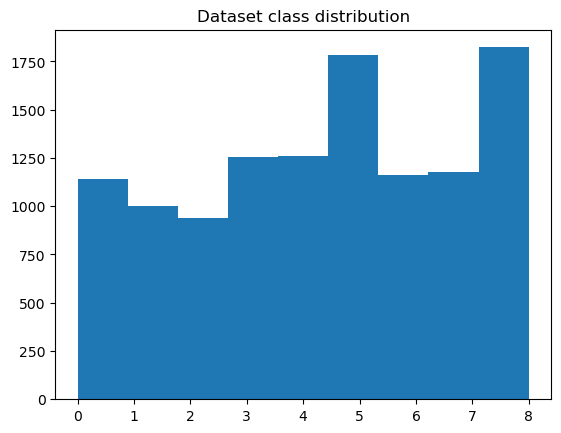

In [44]:
plt.hist([dataset[idx][1] for idx in range(len(dataset))], bins=len(dataset.classes))
plt.title('Dataset class distribution')
plt.show()

Clearly imbalanced

### Stratified train-test split

Split the dataset into training and test sets, taking into account class distribution

In [28]:
train_idx, test_idx = StratifiedSplit(dataset)

# Create datasets for train and test
train_dataset = CustomImageDataset(dataset, train_idx, transform=trans_comp_coppo)
test_dataset = CustomImageDataset(dataset, test_idx, transform=trans_comp_coppo)
# Need to call trans_comp_vgg_color again because train_idx, test_idx are just indices

Check whether test set class distribution resembles the original

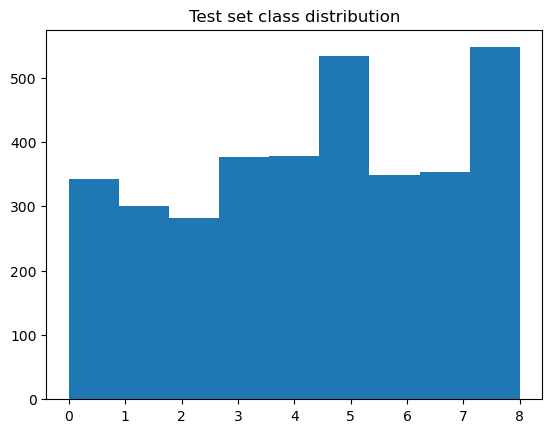

In [47]:
plt.hist([test_dataset[idx][1] for idx in range(len(test_dataset))], bins=len(dataset.classes))
plt.title('Test set class distribution')
plt.show()

### Stratified K-fold sampling

#### Visualization

Visualize stratified K-fold. For the sake of clarity, we will only plot the first 4 classes

In [48]:
splits = 4
reps = 2
rskf = RepeatedStratifiedKFold(n_repeats=reps, n_splits=splits)
skf = StratifiedKFold(n_splits=splits, shuffle=False)

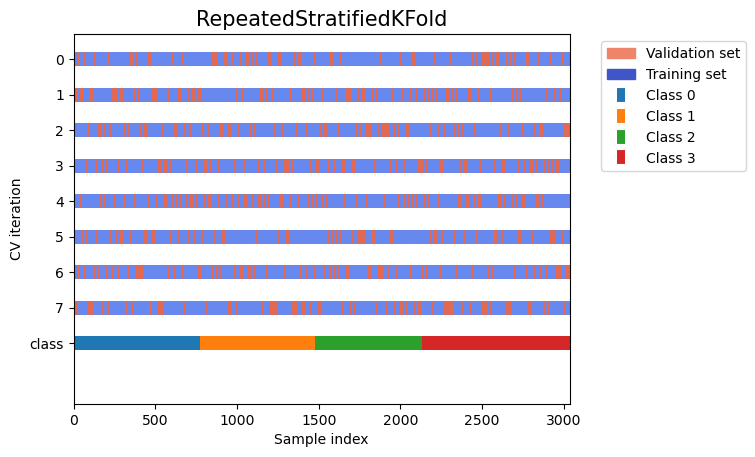

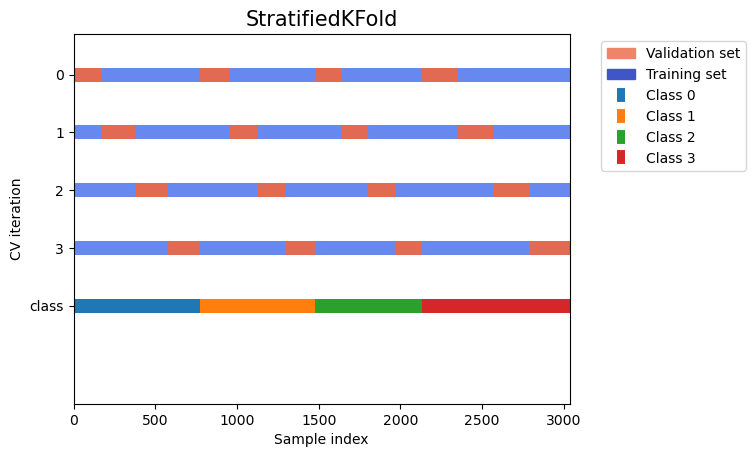

In [52]:
StratifiedKFoldVisual(train_dataset, rskf, mask_len = 4, test_title='Validation set')
StratifiedKFoldVisual(train_dataset, skf, mask_len = 4, test_title='Validation set')

#### Implementation

The '''split''' method in (Repeated)StratifiedKFold returns the array of indices relative to a the test and validation set of a given fold.
Here, we check whether one of these folds respects the original class distribution

In [53]:
X_train = np.array(train_dataset.images)
y_train = np.array(train_dataset.targets)

In [54]:
for fold, (train_index, val_index) in enumerate(rskf.split(X_train, y_train)):
    if fold == 0:  # Only take the first fold
        train_fold_sub = torch.utils.data.Subset(train_dataset, train_idx)
        val_fold_sub = torch.utils.data.Subset(train_dataset, test_idx)
        break  # Exit after the first fold

Check whether class distribution resembles the original

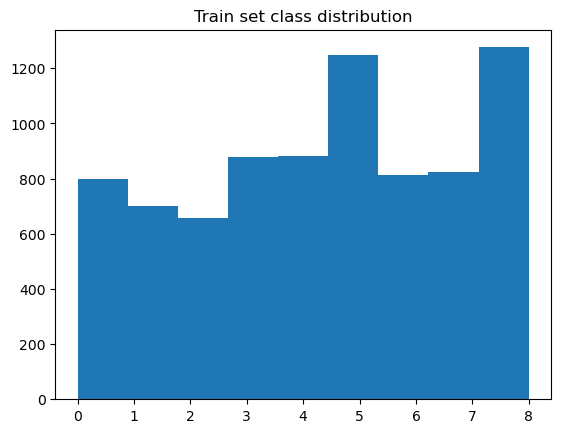

In [55]:
plt.hist(train_fold_sub.dataset.targets, bins=len(dataset.classes))
plt.title('Train set class distribution')
plt.show()

### Check images

Simple visualization to check whether images are loaded correctly

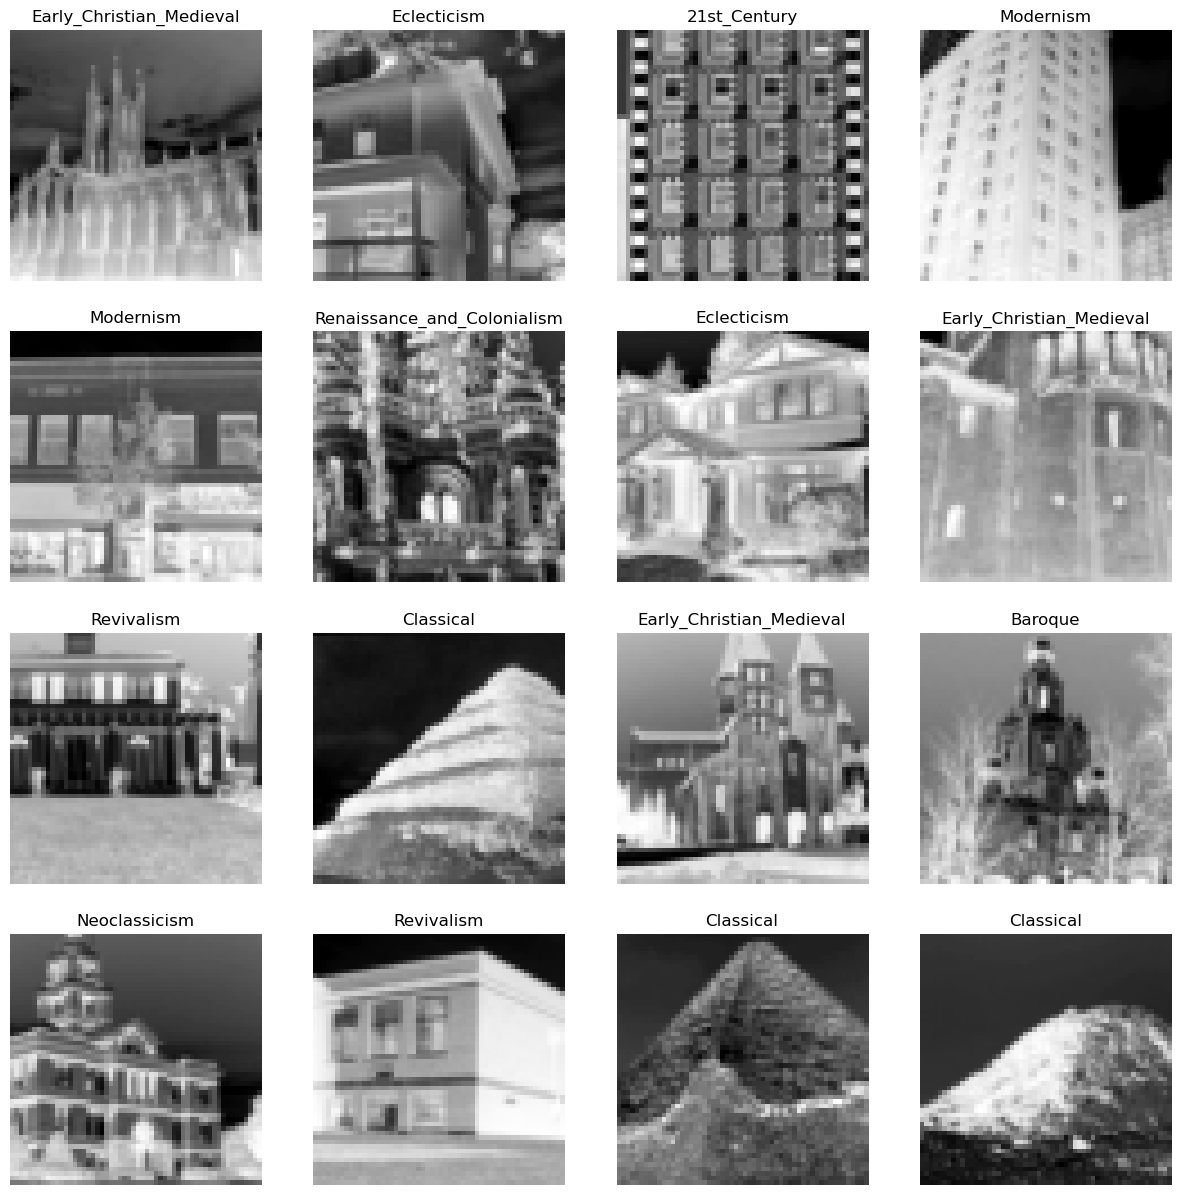

In [25]:
fig = plt.figure(figsize=(15, 15))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = random.randint(0, len(train_dataset)-1)
    img = train_dataset[random_idx][0]
    label = label_dictionary[train_dataset[random_idx][1]]
    fig.add_subplot(rows, cols, i)
    img = img.permute(1,2,0)
    plt.imshow(img, cmap = "binary", interpolation = "nearest")
    plt.title(label)
    plt.axis(False);

## Hyperparameter search

Cross validator selection

In [29]:
splits = 3
reps = 2
rskf = StratifiedKFold(n_splits=splits)

Criterion selection

In [30]:
loss = nn.CrossEntropyLoss()

Early stopper init

In [31]:
pruner = EarlyStopper(patience=3, min_delta=0.2)

### ArtCoppo b&w

#### Hyperparameter search

In [ ]:
# Create Optuna study and optimize with additional parameters
study_coppo = optuna.create_study(direction="minimize")
study_coppo.optimize(partial(objective_coppo64, dataset=train_dataset, model_class=ArtCoppo64, criterion=loss, cross_validator=rskf, device=device, early_stopper=pruner), n_trials=10)

[I 2024-12-11 12:23:29,779] A new study created in memory with name: no-name-e471e052-a0e2-4bd0-a6cd-c044b7b600e7
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 8, 16, 32] which is of type list.
  warnings.warn(message)
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [6, 16, 32, 64] which is of type list.
  warnings.warn(message)
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [3, 9, 15, 45] which is of type list.
  warnings.warn(message)


Started fold: 1, epoch: 1


Started fold: 1, epoch: 2


Started fold: 1, epoch: 3


Started fold: 1, epoch: 4


Started fold: 1, epoch: 5


Started fold: 1, epoch: 6


Folds: 1fold [03:48, 228.17s/fold]

Started fold: 2, epoch: 1


Started fold: 2, epoch: 2


Started fold: 2, epoch: 3


Started fold: 2, epoch: 4


Started fold: 2, epoch: 5


Started fold: 2, epoch: 6


Folds: 2fold [07:34, 227.11s/fold]

Started fold: 3, epoch: 1


Started fold: 3, epoch: 2


Started fold: 3, epoch: 3


Started fold: 3, epoch: 4


Started fold: 3, epoch: 5


Started fold: 3, epoch: 6


Folds: 3fold [11:26, 228.86s/fold]
[I 2024-12-11 12:34:56,381] Trial 0 finished with value: 2.0196156894459443 and parameters: {'lr': 0.00014104520964516523, 'weight_decay': 0.005578082088926672, 'hidden_channels': [6, 16, 32, 64]}. Best is trial 0 with value: 2.0196156894459443.
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 8, 16, 32] which is of type list.
  warnings.warn(message)
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [6, 16, 32, 64] which is of type list.
  warnings.warn(message)
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categoric

Started fold: 1, epoch: 1


Started fold: 1, epoch: 2


Started fold: 1, epoch: 3


Started fold: 1, epoch: 4


Started fold: 1, epoch: 5


Started fold: 1, epoch: 6


Folds: 1fold [03:46, 226.69s/fold]

Started fold: 2, epoch: 1


Started fold: 2, epoch: 2


Started fold: 2, epoch: 3


Started fold: 2, epoch: 4


Started fold: 2, epoch: 5


Started fold: 2, epoch: 6


Folds: 2fold [07:34, 227.26s/fold]

Started fold: 3, epoch: 1


Started fold: 3, epoch: 2


Started fold: 3, epoch: 3


Started fold: 3, epoch: 4


Started fold: 3, epoch: 5


Started fold: 3, epoch: 6


Folds: 3fold [11:21, 227.29s/fold]
[I 2024-12-11 12:46:18,271] Trial 1 finished with value: 2.133126113461513 and parameters: {'lr': 0.0003349864270350356, 'weight_decay': 0.013564432130361787, 'hidden_channels': [3, 9, 15, 45]}. Best is trial 0 with value: 2.0196156894459443.
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 8, 16, 32] which is of type list.
  warnings.warn(message)
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [6, 16, 32, 64] which is of type list.
  warnings.warn(message)
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical 

Started fold: 1, epoch: 1


Started fold: 1, epoch: 2


Started fold: 1, epoch: 3


Started fold: 1, epoch: 4


Started fold: 1, epoch: 5


Started fold: 1, epoch: 6


Folds: 1fold [03:46, 226.42s/fold]

Started fold: 2, epoch: 1


Started fold: 2, epoch: 2


Started fold: 2, epoch: 3


Started fold: 2, epoch: 4


Started fold: 2, epoch: 5


Started fold: 2, epoch: 6


Folds: 2fold [07:34, 227.39s/fold]

Started fold: 3, epoch: 1


Started fold: 3, epoch: 2


Started fold: 3, epoch: 3


Started fold: 3, epoch: 4


Started fold: 3, epoch: 5


Started fold: 3, epoch: 6


Folds: 3fold [11:23, 227.88s/fold]
[I 2024-12-11 12:57:41,928] Trial 2 finished with value: 2.1107075120888505 and parameters: {'lr': 2.667982090829151e-05, 'weight_decay': 0.004372527860928561, 'hidden_channels': [3, 9, 15, 45]}. Best is trial 0 with value: 2.0196156894459443.
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 8, 16, 32] which is of type list.
  warnings.warn(message)
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [6, 16, 32, 64] which is of type list.
  warnings.warn(message)
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical

Started fold: 1, epoch: 1


Started fold: 1, epoch: 2


Started fold: 1, epoch: 3


Started fold: 1, epoch: 4


Started fold: 1, epoch: 5


Started fold: 1, epoch: 6


Folds: 1fold [03:47, 227.39s/fold]

Started fold: 2, epoch: 1


Started fold: 2, epoch: 2


Started fold: 2, epoch: 3


Started fold: 2, epoch: 4


Started fold: 2, epoch: 5


Started fold: 2, epoch: 6


Folds: 2fold [07:35, 227.55s/fold]

Started fold: 3, epoch: 1


Started fold: 3, epoch: 2


Started fold: 3, epoch: 3


Started fold: 3, epoch: 4


Started fold: 3, epoch: 5


Started fold: 3, epoch: 6


Folds: 3fold [11:21, 227.31s/fold]
[I 2024-12-11 13:09:03,878] Trial 3 finished with value: 2.2049122988008985 and parameters: {'lr': 0.016588965726977146, 'weight_decay': 0.00896516897531489, 'hidden_channels': [3, 9, 15, 45]}. Best is trial 0 with value: 2.0196156894459443.
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 8, 16, 32] which is of type list.
  warnings.warn(message)
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [6, 16, 32, 64] which is of type list.
  warnings.warn(message)
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical d

Started fold: 1, epoch: 1


Started fold: 1, epoch: 2


Started fold: 1, epoch: 3


Started fold: 1, epoch: 4


Started fold: 1, epoch: 5


Started fold: 1, epoch: 6


Started fold: 1, epoch: 7


Started fold: 1, epoch: 8


Folds: 1fold [05:09, 309.58s/fold]

Started fold: 2, epoch: 1


Started fold: 2, epoch: 2


Started fold: 2, epoch: 3


Started fold: 2, epoch: 4


Started fold: 2, epoch: 5


Started fold: 2, epoch: 6


Folds: 2fold [09:03, 265.17s/fold]

Started fold: 3, epoch: 1


Started fold: 3, epoch: 2


Started fold: 3, epoch: 3


Started fold: 3, epoch: 4


Started fold: 3, epoch: 5


Started fold: 3, epoch: 6


Folds: 3fold [12:58, 259.44s/fold]
[I 2024-12-11 13:22:02,196] Trial 4 finished with value: 1.7917444500268676 and parameters: {'lr': 0.0010244030498645631, 'weight_decay': 0.0017315042173475506, 'hidden_channels': [6, 16, 32, 64]}. Best is trial 4 with value: 1.7917444500268676.
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 8, 16, 32] which is of type list.
  warnings.warn(message)
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [6, 16, 32, 64] which is of type list.
  warnings.warn(message)
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categoric

Started fold: 1, epoch: 1


Started fold: 1, epoch: 2


Started fold: 1, epoch: 3


Started fold: 1, epoch: 4


Started fold: 1, epoch: 5


Started fold: 1, epoch: 6


Folds: 1fold [03:48, 228.98s/fold]

Started fold: 2, epoch: 1


Started fold: 2, epoch: 2


Started fold: 2, epoch: 3


Started fold: 2, epoch: 4


Started fold: 2, epoch: 5


Started fold: 2, epoch: 6


Folds: 2fold [07:38, 229.20s/fold]

Started fold: 3, epoch: 1


Started fold: 3, epoch: 2


Started fold: 3, epoch: 3


Started fold: 3, epoch: 4


Started fold: 3, epoch: 5


Started fold: 3, epoch: 6


Folds: 3fold [11:28, 229.38s/fold]
[I 2024-12-11 13:33:30,359] Trial 5 finished with value: 2.09757056797252 and parameters: {'lr': 0.0001439526689685844, 'weight_decay': 0.009046603081610722, 'hidden_channels': [3, 9, 15, 45]}. Best is trial 4 with value: 1.7917444500268676.
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 8, 16, 32] which is of type list.
  warnings.warn(message)
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [6, 16, 32, 64] which is of type list.
  warnings.warn(message)
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical d

Started fold: 1, epoch: 1


Started fold: 1, epoch: 2


Started fold: 1, epoch: 3


Started fold: 1, epoch: 4


Started fold: 1, epoch: 5


Started fold: 1, epoch: 6


Folds: 1fold [03:55, 235.20s/fold]

Started fold: 2, epoch: 1


Started fold: 2, epoch: 2


Started fold: 2, epoch: 3


Started fold: 2, epoch: 4


Started fold: 2, epoch: 5


Started fold: 2, epoch: 6


Folds: 2fold [07:50, 235.09s/fold]

Started fold: 3, epoch: 1


Started fold: 3, epoch: 2


Started fold: 3, epoch: 3


Started fold: 3, epoch: 4


Started fold: 3, epoch: 5


Started fold: 3, epoch: 6


Folds: 3fold [11:43, 234.52s/fold]
[I 2024-12-11 13:45:13,929] Trial 6 finished with value: 2.168408588334626 and parameters: {'lr': 1.533331291720239e-05, 'weight_decay': 0.05498467725731655, 'hidden_channels': [6, 16, 32, 64]}. Best is trial 4 with value: 1.7917444500268676.
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 8, 16, 32] which is of type list.
  warnings.warn(message)
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [6, 16, 32, 64] which is of type list.
  warnings.warn(message)
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical 

Started fold: 1, epoch: 1


Started fold: 1, epoch: 2


Started fold: 1, epoch: 3


Started fold: 1, epoch: 4


Started fold: 1, epoch: 5


Started fold: 1, epoch: 6


Folds: 1fold [03:51, 231.66s/fold]

Started fold: 2, epoch: 1


Started fold: 2, epoch: 2


Started fold: 2, epoch: 3


Started fold: 2, epoch: 4


Started fold: 2, epoch: 5


Started fold: 2, epoch: 6


Folds: 2fold [07:43, 232.05s/fold]

Started fold: 3, epoch: 1


Started fold: 3, epoch: 2


Started fold: 3, epoch: 3


Started fold: 3, epoch: 4


Started fold: 3, epoch: 5


Started fold: 3, epoch: 6


Folds: 3fold [11:37, 232.40s/fold]
[I 2024-12-11 13:56:51,143] Trial 7 finished with value: 2.181503971417745 and parameters: {'lr': 0.018913674449784982, 'weight_decay': 0.00020217656948807913, 'hidden_channels': [6, 16, 32, 64]}. Best is trial 4 with value: 1.7917444500268676.
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 8, 16, 32] which is of type list.
  warnings.warn(message)
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [6, 16, 32, 64] which is of type list.
  warnings.warn(message)
/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorica

Started fold: 1, epoch: 1


Started fold: 1, epoch: 2


#### Hyperparameter report

In [32]:
print("Best hyperparameters:", study_coppo.best_params)
print("Best validation loss:", study_coppo.best_value)

NameError: name 'study_coppo' is not defined

In [ ]:
best_trial_coppo = study_coppo.best_trial
hyperparameter_report(best_trial_coppo)

### VGG19

Send model to selected device and modify the classifier to fit classification purposes

In [ ]:
vgg19.classifier[6] = nn.Linear(vgg19.classifier[6].in_features, len(dataset.classes), bias=True)
vgg19 = vgg19.to(device)

Start search

In [ ]:
# Create Optuna study and optimize with additional parameters
study_vgg19 = optuna.create_study(direction="minimize")
study_vgg19.optimize(lambda trial: objective_vgg(trial, train_dataset, vgg19, loss, rskf, device, pruner), n_trials=10)

#### Hyperparameter search report

Best parameters and loss

In [ ]:
print("Best hyperparameters:", study.best_params)
print("Best validation loss:", study.best_value)

Plotting

In [ ]:
best_trial_vgg19 = study.vgg19.best_trial
hyperparameter_report(best_trial_vgg19)

### VGG19 finetuning

Freeze feature gradients, we only train the classifier

The last step of the classifier need to be modified to accomodate the number of target classes

In [ ]:
vgg19 = torchvision.models.vgg19(pretrained=True)
for param in vgg19.features:
    param.requires_grad = False
vgg19.classifier[6] = nn.Linear(vgg19.classifier[6].in_features, len(dataset.classes), bias=True)

## Model training

### ArtCoppo64

In [33]:
best_pars = {'lr': 0.0010244030498645631, 'weight_decay': 0.0017315042173475506, 'hidden_channels': [6, 16, 32, 64]}

In [34]:
log_coppo64_str = LOGGING_FOLDER+'log_coppo64.txt'

In [ ]:
train_loop(train_dataset, ArtCoppo64, best_pars, loss, device, pruner, log_coppo64_str)

Epochs:   0%|          | 0/100 [00:00<?, ?epoch/s]

In [ ]:
plot_metrics(log_vgg19_str)

### vgg19

In [ ]:
log_vgg19_str = LOGGING_FOLDER+'log_vgg19.txt'

In [ ]:
train_loop(train_dataset, vgg19, study.vgg19.best_params, loss, device, 50, pruner, log_vgg19_str)

In [ ]:
plot_metrics(log_vgg19_str)